## Loading data

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

import scipy.sparse as sp
import warnings
import os

warnings.filterwarnings("ignore")

os.environ["R_HOME"] = "/home/lxx/.conda/envs/r4Base/lib/R"
os.environ["R_USER"] = "/home/lxx/.local/lib/python3.9/site-packages/rpy2"

import spCLUE

spCLUE.fix_seed(0)

In [2]:
n_clusters = 9

sample_name = "slideSeqV2_mob"
data_file = f"../dataset/SLIDESEQV2/{sample_name}.h5ad"
adata = sc.read_h5ad(data_file)
adata.var_names_make_unique()
print(adata)

AnnData object with n_obs × n_vars = 21724 × 21220
    obs: 'array_row', 'array_col', 'used_barcodes'
    obsm: 'spatial'


## Preprocessing and constructing

In [3]:
adata = adata[adata.obs["used_barcodes"]].copy()
sc.pp.filter_genes(adata, min_cells=50)
adata = spCLUE.preprocess(adata)
adata.obsm["X_pca"] = PCA(n_components=200, random_state=0).fit_transform(adata.X)

## construct spatial graph and expr graph
g_spatial = spCLUE.prepare_graph(adata, "spatial")
g_expr = spCLUE.prepare_graph(adata, "expr")
graph_dict = {"spatial": g_spatial, "expr": g_expr}

normalized data ---------------->
create adjacent matrix from spatial idx --------------->
create knn graph ---->
spatial knn graph created ----<
create adjacent matrix from pca expr --------------->
create knn graph ---->
expr knn graph created ----<


## Training of spCLUE

In [4]:
spCLUE_model = spCLUE.spCLUE(adata.obsm["X_pca"], graph_dict)

In [5]:
_, adata.obsm["spCLUE"] = spCLUE_model.train()

Training Start =========================>


 20%|██        | 101/500 [00:10<00:42,  9.45it/s]

epoch 100: 0.39723623166054517


 40%|████      | 201/500 [00:21<00:31,  9.48it/s]

epoch 200: 0.3397822153665516


 60%|██████    | 301/500 [00:31<00:21,  9.39it/s]

epoch 300: 0.29099829402473787


 80%|████████  | 401/500 [00:42<00:10,  9.48it/s]

epoch 400: 0.2822645447273706


100%|██████████| 500/500 [00:52<00:00,  9.46it/s]

epoch 500: 0.28487732030385093
Training Finished =================<


## Clustering and visualization

In [7]:
n_clusters_ls = [9, 10, 11]
cluster_methods = "mclust"

for n_clusters in n_clusters_ls:
    _ = spCLUE.clustering(adata, n_clusters, key="spCLUE", cluster_methods=cluster_methods)
    adata.obs[f"spCLUE_{n_clusters}"] = adata.obs["mclust"]

R[write to console]: Package 'mclust' version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



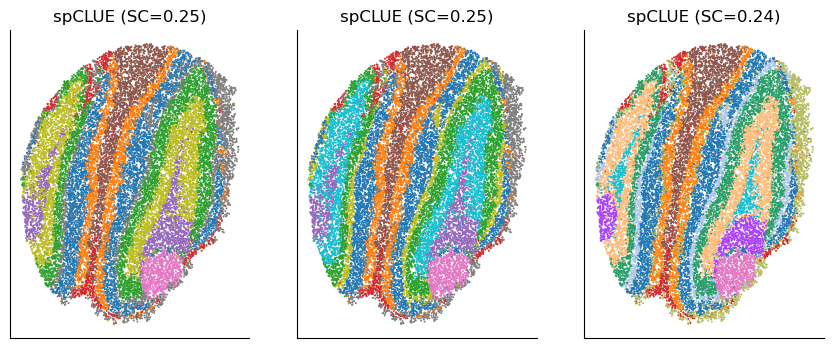

In [9]:
from sklearn.metrics import silhouette_score

fig, axes = plt.subplots(1, 3, figsize=(3.5 * 3, 4))

for i in range(3):
    ax = axes[i]
    cur_obs = f"spCLUE_{n_clusters_ls[i]}"
    adata.obs[cur_obs] = adata.obs[cur_obs].astype("category")
    sc.pl.embedding(adata, basis="spatial", color=f"spCLUE_{n_clusters_ls[i]}", ax=ax, show=False, s=8)
    legend_spCLUE = ax.get_legend_handles_labels()  # [handles, labels]
    ax.legend([], frameon=False)
    sc1 = silhouette_score(adata.obsm["spCLUE"], adata.obs[cur_obs])
    sc_score = np.round(sc1, 2)
    ax.set_title("spCLUE (SC=%.2f)" % (sc_score,))
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)